In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import A2C
from stable_baselines3.common.monitor import Monitor

from environment.env import Simulatio4RecSys

from environment.citations.citation_loader import CitationsLoader
from environment.users.citation_users_loader import CitationUsersLoader

from environment.items_selection import GreedySelector
from environment.reward_perturbator import NoPerturbator
from environment.reward_shaping import IdentityRewardShaping
from environment.citations.citations_retrieval import CitationsRetrieval
from environment.LLM.dummy_llm import DummyLLM
from environment.LLM.rater import DummyLLMRater
from environment.flat_obs_wrapper import FlatObsWrapper

# Loaders
items_loader = CitationsLoader("../environment/citations/datasets/cleaned-scientometrics-and-bibliometrics-research.csv")
users_loader = CitationUsersLoader("../environment/users/datasets/citation_users.json")

# Components
items_selector = GreedySelector()
reward_perturbator = NoPerturbator()
reward_shaping = IdentityRewardShaping()
llm_rater = DummyLLMRater(DummyLLM())

# Environment
raw_env = Simulatio4RecSys(
    render_mode="human",
    items_loader=items_loader,
    users_loader=users_loader,
    items_selector=items_selector,
    reward_perturbator=reward_perturbator,
    items_retrieval=CitationsRetrieval(),
    reward_shaping=reward_shaping,
    llm_rater=llm_rater
)

env = FlatObsWrapper(raw_env)
env = Monitor(env)



In [7]:
obs = env.reset()[0]
action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(action)
print("Step ran. Reward:", reward)

Step ran. Reward: 6.5


In [3]:
import random
import pandas as pd
from environment.users.user import User
from environment.citations.citation import Citation


# ---------------
# Load data
# ---------------

# Load papers
papers_df = pd.read_csv("../environment/citations/datasets/cleaned-scientometrics-and-bibliometrics-research.csv")

# Load users (list of dicts)
import json
with open("../environment/users/datasets/citation_users.json", "r") as f:
    users_data = json.load(f)

# ---------------
# Initialize LLM
# ---------------

# llm = SmallHuggingfaceLLM(model_name="sshleifer/tiny-gpt2", device="cpu")
rater =  DummyLLMRater(DummyLLM())

# ---------------
# Select 1 User
# ---------------

user_info = users_data[0]
user = User(
    name=f"CitationUser{user_info['id']}",
    gender="M",
    age=30,
    description=f"Interested in: {', '.join(user_info['preferred_topics'])}. "
                f"Prefers novelty: {user_info['novelty_preference']}, "
                f"reputability bias: {user_info['reputability_bias']}",
    job="",
    hobby=""
)

print(f"🧑‍💼 User Description: {user.description}")
print()

# ---------------
# Select 30 Random Papers
# ---------------

sample_papers = papers_df.sample(30, random_state=42)

# ---------------
# Rate Papers
# ---------------

results = []

for idx, row in sample_papers.iterrows():
    citation = Citation(
        id=idx,
        title=row["title"],
        year=row["publication_year"],
        topics=eval(row["topics.display_name"]),
        topic_scores=eval(row["topics.score"]),
        cited_by_count=row["cited_by_count"],
        norm_cite=row["cited_by_count_norm"],
        norm_year=row["publication_year_norm"]
    )

    # Query LLM
    rating, explanation, _ = rater.query(
        user=user,
        item=citation,
        num_interacted=0,
        interactions=[],
        retrieved_items=[]
    )

    results.append({
        "Paper Title": citation.title,
        "Publication Year": citation.year,
        "Cited By Count": citation.cited_by_count,
        "Topics": ", ".join(citation.topics),
        "Normalized Cite": citation.norm_cite,
        "Normalized Year": citation.norm_year,
        "LLM Rating (0-9)": rating
    })

# ---------------
# View Results
# ---------------

results_df = pd.DataFrame(results)
display(results_df)


🧑‍💼 User Description: Interested in: Web visibility and informetrics. Prefers novelty: 0.74, reputability bias: 0.47



,Paper Title,Publication Year,Cited By Count,Topics,Normalized Cite,Normalized Year,LLM Rating (0-9)
0,Correlational analysis of topic specificity an...,2018,20,"scientometrics and bibliometrics research, Com...",0.295771,0.993555,6.5
1,Infrastructures de science ouverte,2024,0,scientometrics and bibliometrics research,0.000000,0.999091,6.5
2,How can we assess scientific quality? Citation...,2014,5,"scientometrics and bibliometrics research, Met...",0.154523,0.989781,6.5
3,The Torsion Balance Company,1973,1,scientometrics and bibliometrics research,0.050013,0.946613,6.5
4,Practice and Challenge of International Peer R...,2019,2,scientometrics and bibliometrics research,0.085497,0.994488,6.5
5,How an editorial in a scientific journal can h...,2023,0,scientometrics and bibliometrics research,0.000000,0.998179,6.5
6,The BiPublishers ranking: Main results and met...,2015,0,scientometrics and bibliometrics research,0.000000,0.990731,6.5
7,British Association for the Advancement of Sci...,1955,4,scientometrics and bibliometrics research,0.135510,0.924448,6.5
8,“The chemistry and technology of the diazo‐com...,1920,0,scientometrics and bibliometrics research,0.000000,0.873243,6.5
9,Scientometrics: Methodology and Tools,2016,3,"scientometrics and bibliometrics research, Res...",0.113021,0.991677,6.5


In [3]:
# Train
model = A2C("MultiInputPolicy", env, verbose=1, device='cpu')
model.learn(total_timesteps=10000)
# model.save("models/a2c_citation_recommender")

# Plot rewards
rewards = env.get_episode_rewards()
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title("A2C - Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.tight_layout()
plt.show()


Using cpu device
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 34.6     |
|    ep_rew_mean        | 225      |
| time/                 |          |
|    fps                | 73       |
|    iterations         | 100      |
|    time_elapsed       | 6        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -10.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 203      |
|    value_loss         | 430      |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 35.7     |
|    ep_rew_mean        | 232      |
| time/                 |          |
|    fps                | 72       |
|    iterations         | 200      |
|    time_elapsed       | 13       |
|    total_timesteps   

KeyboardInterrupt: 

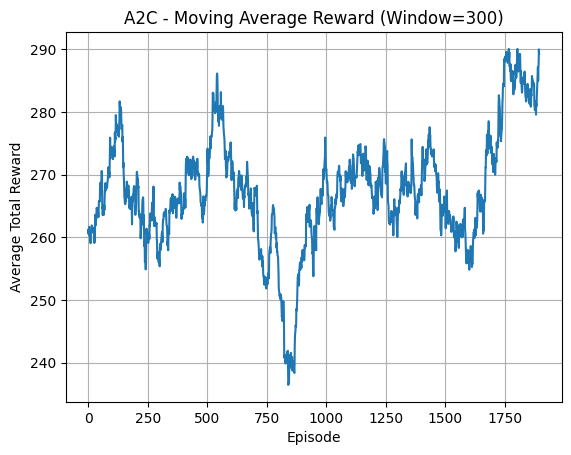

In [ ]:
window_size = 300
moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

# Plot
plt.plot(moving_avg)
plt.title(f"A2C - Moving Average Reward (Window={window_size})")
plt.xlabel("Episode")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.show()

In [30]:
# --- Reset until target user ---
target_user_name = "CitationUser23"

while True:
    obs, _ = env.reset()
    user = env.unwrapped._user
    if user.name == target_user_name:
        break

# --- Predict top recommendation ---
action, _ = model.predict(obs, deterministic=True)
action = int(action)  # ✅ ensure it's an int
item_id = env.unwrapped.action_to_item[action]
citation = env.unwrapped.items_loader.load_items_from_ids([item_id])[0]

# --- Print output ---
print("="*50)
print(f"👤 USER PROFILE")
print(f"   Name    : {user.name}")
print(f"   Gender  : {user.gender}")
print(f"   Age     : {user.age}")
print(f"   Prefs   : {user.description}")
print()

print(f"📚 RECOMMENDED PAPER")
print(f"   Title   : {citation.title}")
print(f"   Year    : {citation.year}")
print(f"   Topics  : {', '.join(citation.topics)}")
print(f"   Citations: {citation.cited_by_count}")
print(f"   Norm. Year     : {citation.norm_year:.2f}")
print(f"   Norm. Citations: {citation.norm_cite:.2f}")
print("="*50)


👤 USER PROFILE
   Name    : CitationUser23
   Gender  : M
   Age     : 30
   Prefs   : Interested in: Science and Science Education, Meta-analysis and systematic reviews, Chemistry and Chemical Engineering. Prefers novelty: 0.39, reputability bias: 0.99

📚 RECOMMENDED PAPER
   Title   : BRITISH ASSOCIATION FOR THE ADVANCEMENT OF SCIENCE
   Year    : 1914
   Topics  : scientometrics and bibliometrics research
   Citations: 6
   Norm. Year     : 0.86
   Norm. Citations: 0.17


In [4]:
from stable_baselines3 import DQN

model = DQN(
    policy="MultiInputPolicy",
    env=env,
    verbose=1,
    learning_rate=1e-4,        # Feel free to tune
    buffer_size=10000,         # Replay buffer size
    learning_starts=1000,      # Delay learning until some experiences are collected
    batch_size=64,
    train_freq=1,
    target_update_interval=500,
    device="cpu",              # Or "cuda" if available
)

model.learn(total_timesteps=50000)
# model.save("models/dqn_citation_recommender")


Using cpu device
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.5     |
|    ep_rew_mean      | 133      |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1087     |
|    time_elapsed     | 0        |
|    total_timesteps  | 82       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 33       |
|    ep_rew_mean      | 214      |
|    exploration_rate | 0.95     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 847      |
|    time_elapsed     | 0        |
|    total_timesteps  | 264      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26.8     |
|    ep_rew_mean      | 174      |
|    exploration_rate | 0.939    |
| t

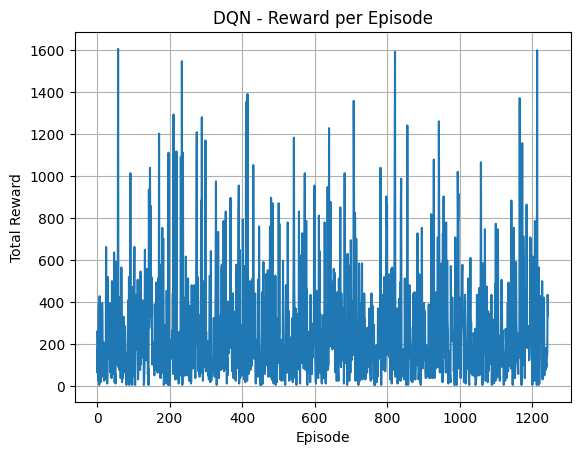

In [6]:
rewards = env.get_episode_rewards()
plt.plot(rewards)
plt.title("DQN - Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


In [14]:
len(rewards)

1245

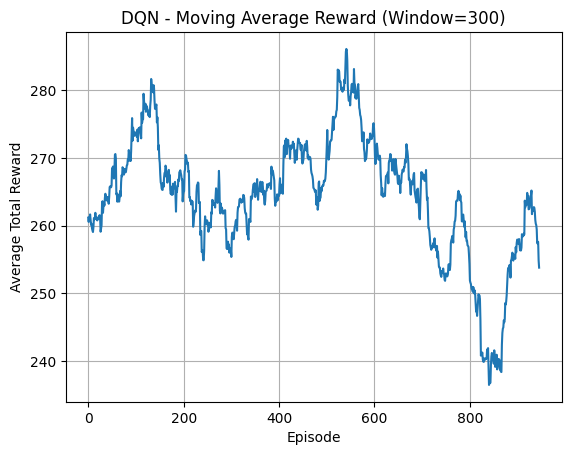

In [13]:
window_size = 300
moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

# Plot
plt.plot(moving_avg)
plt.title(f"DQN - Moving Average Reward (Window={window_size})")
plt.xlabel("Episode")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.show()

In [16]:
# --- Reset until target user ---
target_user_name = "CitationUser1"

while True:
    obs, _ = env.reset()
    user = env.unwrapped._user
    if user.name == target_user_name:
        break

# --- Predict top recommendation ---
action, _ = model.predict(obs, deterministic=True)
action = int(action)  # ✅ ensure it's an int
item_id = env.unwrapped.action_to_item[action]
citation = env.unwrapped.items_loader.load_items_from_ids([item_id])[0]

# --- Print output ---
print("="*50)
print(f"👤 USER PROFILE")
print(f"   Name    : {user.name}")
print(f"   Gender  : {user.gender}")
print(f"   Age     : {user.age}")
print(f"   Prefs   : {user.description}")
print()

print(f"📚 RECOMMENDED PAPER")
print(f"   Title   : {citation.title}")
print(f"   Year    : {citation.year}")
print(f"   Topics  : {', '.join(citation.topics)}")
print(f"   Citations: {citation.cited_by_count}")
print(f"   Norm. Year     : {citation.norm_year:.2f}")
print(f"   Norm. Citations: {citation.norm_cite:.2f}")
print("="*50)


👤 USER PROFILE
   Name    : CitationUser1
   Gender  : M
   Age     : 30
   Prefs   : Interested in: Science and Science Education, Intellectual Capital and Performance Analysis, Innovation Policy and R&D. Prefers novelty: 0.5, reputability bias: 0.65

📚 RECOMMENDED PAPER
   Title   : Of the two great departments of science.
   Year    : 2008
   Topics  : scientometrics and bibliometrics research, Interdisciplinary Research and Collaboration
   Citations: 0
   Norm. Year     : 0.98
   Norm. Citations: 0.00
